Install the following packages
I may not need most of it I can decide later

MONAI
SimpleITK
medpy
opencv


In [1]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision,tqdm]==0.6.0"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import cv2" || pip install opencv-python

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.8/584.8 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 KB 19.7 MB/s eta 0:00:00


In [2]:
!python -c "import SimpleITK" || pip install -q SimpleITK
!python -c "import medpy" || pip install -q medpy

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'SimpleITK'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.9 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'medpy'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import monai
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
import SimpleITK as sitk
import medpy

In [5]:
import PIL

In [6]:
from monai.config import print_config
print_config()

MONAI version: 0.6.0
Numpy version: 1.22.4
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.11.2
gdown version: 4.4.0
TorchVision version: 0.14.1+cu116
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Setup the Data Directory

In [7]:
import os
import shutil
import tempfile
from pathlib import Path

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%env DATA_DIRECTORY = /content/drive/MyDrive/LVEF

env: DATA_DIRECTORY=/content/drive/MyDrive/LVEF


In [10]:
directory = os.environ.get("DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/content/drive/MyDrive/LVEF


In [22]:
CAMUS_ORIGINAL_DATA_DIR = 'CAMUS/original_data/data'
CAMUS_DATA_DIR = 'New_CAMUS_png/CAMUS'

In [25]:
def checkPathExists(path):
  if not os.path.exists(path):
    print(f"Cannot access path: {path}")
  else:
    print (f"Path {path} accessible")

In [26]:
path_dir = Path(os.path.join(root_dir, CAMUS_DATA_DIR))
checkPathExists(path_dir)

Path /content/drive/MyDrive/LVEF/New_CAMUS_png/CAMUS accessible


In [13]:
from monai.utils import set_determinism
set_determinism(seed=0)

In [14]:

TRAINING_DATA_DIR = Path(os.path.join(path_dir, 'Training'))
TESTING_DATA_DIR = Path(os.path.join(root_dir, 'Testing'))

In [15]:
import pprint
pp = pprint.PrettyPrinter()

In [16]:
### Set the file list as
#[ 
#   ED [(input_file, mask_file), (input_file, mask_file), ....]
#   ES [(input_file, mask_file), (input_file, mask_file), ....]
#]

TWO_CHANNEL = '2CH'
FOUR_CHANNEL = '4CH'
PHASE_NAMES = ['ED', 'ES']
num_phases = len(PHASE_NAMES)
patient_list = [x for x in TRAINING_DATA_DIR.iterdir() if x.is_dir()]

image_files_2ch = [
    [
        (p, Path(str(p).replace(f"{PHASE_NAMES[i]}", f"{PHASE_NAMES[i]}_gt")))
        for x in patient_list
        for j, p in enumerate(x.glob(f"**/{TWO_CHANNEL}*{PHASE_NAMES[i]}.png"))
    ]
    for i in range(num_phases)
]

image_files_4ch = [
    [
        (p, Path(str(p).replace(f"{PHASE_NAMES[i]}", f"{PHASE_NAMES[i]}_gt")))
        for x in patient_list
        for j, p in enumerate(x.glob(f"**/{FOUR_CHANNEL}*{PHASE_NAMES[i]}.png"))
    ]
    for i in range(num_phases)
]
#pp.pprint(image_files_2ch[0][0][0])

In [17]:
num_total_2ch = len(image_files_2ch[0])
num_total_4ch = len(image_files_4ch[0])
image_width_2ch, image_height_2ch = PIL.Image.open(image_files_2ch[0][0][0]).size
image_width_4ch, image_height_4ch = PIL.Image.open(image_files_4ch[0][0][0]).size
print(f"Total 2 channel Image Count: {num_total_2ch}")
print(f"Total 4 channel Image Count: {num_total_4ch}")
print(f"2 channel Image Dimensions: {image_width_2ch} x {image_height_2ch}")
print(f"4 channel Image Dimensions: {image_width_4ch} x {image_height_4ch}")

Total 2 channel Image Count: 400
Total 4 channel Image Count: 400
2 channel Image Dimensions: 256 x 256
4 channel Image Dimensions: 256 x 256


Pick images to visualize

In [18]:
import tensorflow as tf

In [84]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    z_min, z_max = np.abs(mask).min(), np.abs(mask).max()
    plt.imshow(mask, cmap=cmap, alpha=alpha, vmin = z_min, vmax=z_max)

0 257
1 321
2 57
3 291


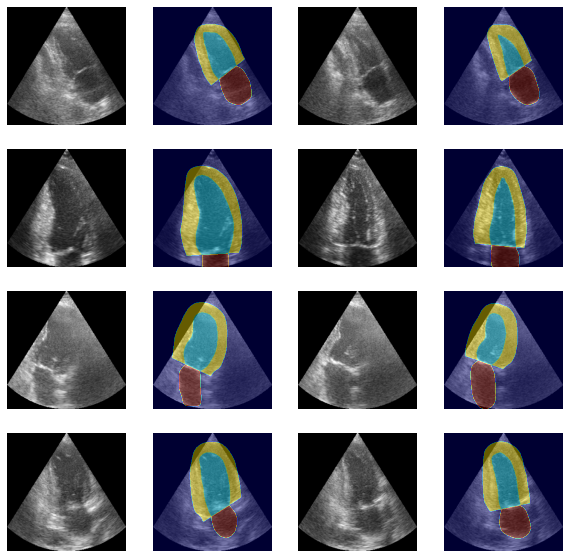

In [96]:
#Pick images to visualize
plt.subplots(4, 4, figsize=(10,10))
for i, k in enumerate(np.random.randint(num_total_2ch, size=4)):
  print(i,k)
  for x in range(2):
    for y in range(2):
      im = PIL.Image.open(image_files_2ch[x][k][y])
      #print(image_files_2ch[x][k][y])
      arr = np.array(im)
      col = 2*x+y
      plt.subplot(4, 4, 4*i+col+1)
      plt.axis('off')
      if y%2==0:
        show_image(arr)
      else:
        arr = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
        show_mask(arr1, arr, cmap='jet')
      arr1 = arr.copy()
      #plt.imshow(arr, cmap="gray", vmin=0, vmax=255)

Checking the original data

In [27]:
original_data_dir = Path(os.path.join(root_dir, CAMUS_ORIGINAL_DATA_DIR))
checkPathExists(original_data_dir)


Path /content/drive/MyDrive/LVEF/CAMUS/original_data/data accessible


In [45]:
training_original_2ch_dir = Path(os.path.join(original_data_dir, 'training/2ch'))
checkPathExists(training_original_2ch_dir)

Path /content/drive/MyDrive/LVEF/CAMUS/original_data/data/training/2ch accessible


In [44]:
training_original_4ch_dir = Path(os.path.join(original_data_dir, 'training/4ch'))
checkPathExists(training_original_4ch_dir)

Path /content/drive/MyDrive/LVEF/CAMUS/original_data/data/training/4ch accessible


In [55]:
import cv2

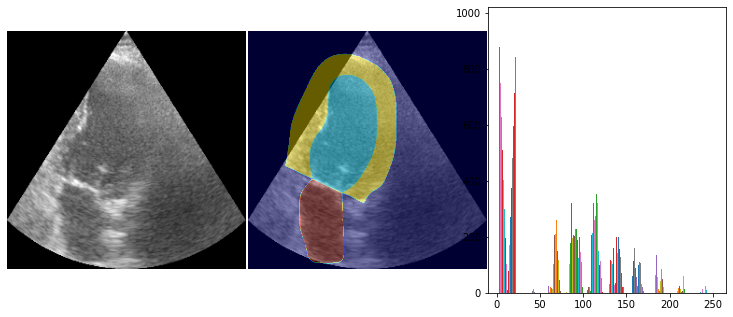

In [99]:
import SimpleITK as sitk
import matplotlib.pylab as plt
pt_num = '0058'
data_ED_file = Path(os.path.join(training_original_2ch_dir, f"frames/patient{pt_num}_2CH_ED.mhd"))
data_ED_GT_file = Path(os.path.join(training_original_2ch_dir, f"masks/patient{pt_num}_2CH_ED_gt.mhd"))
image = sitk.GetArrayFromImage(sitk.ReadImage(data_ED_file, sitk.sitkFloat32))
mask = sitk.GetArrayFromImage(sitk.ReadImage(data_ED_GT_file, sitk.sitkFloat32))
plt.figure(figsize=(20,20))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.01)
image_size=256
image = np.array(tf.squeeze(image))
mask = np.array(tf.squeeze(mask))
image1 = cv2.resize(image,(image_size,image_size))
mask1 = cv2.resize(mask,(image_size, image_size))
plt.subplot(5, 6, 1)
show_image(image1), plt.axis('off')
plt.subplot(5, 6, 2)
show_mask(image1, mask1, cmap='jet'), plt.axis('off')
plt.subplot(5, 6, 3)
plt.hist(image)
plt.show()